In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
def sample_from_semi_circle(n, r, mu):
    def sample_k(k):
        xys = np.random.uniform((-r-mu,0), (r-mu, r), (k,2))
        dist = np.sqrt((xys[:,0]+mu)**2 + xys[:,1]**2)
        return xys[dist <= r]
    ret = sample_k(2*n)
    while ret.size//2 < n:
        ret = np.vstack([ret, sample_k(2*n)])
    return ret[:n, :]

In [3]:
r = 2
mu = 1
samples =sample_from_semi_circle(1000000, r,mu)

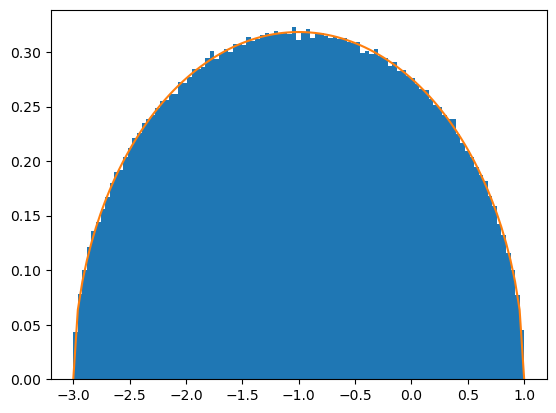

In [4]:
def Px(x, r, mu):
    #if x < -r-mu or x > r-mu:
    #    return 0.0
    ret = 2*np.sqrt(r**2 - (x+mu)**2)/(np.pi*r*r)
    ret[np.argwhere(np.isnan(ret))] = 0
    return ret
bins=np.linspace(-r-mu, r-mu, 100)    
plt.hist(samples[:,0], bins, density=True)
plt.plot(bins, Px(bins, r, mu))
plt.show()

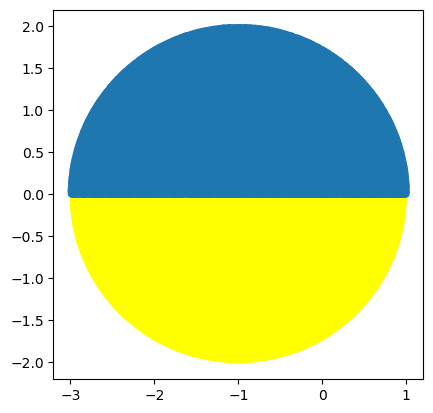

In [102]:
fig = plt.figure()
ax = fig.subplots()
circle1 = plt.Circle((-mu, 0), r, color='yellow')
ax.add_patch(circle1)
ax.scatter(samples[:,0], samples[:,1], marker='.', alpha=.2)
ax.set_aspect('equal', adjustable='box')
plt.show()

In [287]:

def p_circle(x, r, mu):
    vs = (2/(np.pi*r))*np.sqrt(r**2 - (x+mu)**2)
    #vs[np.isnan(vs)] = 0.0
    return vs

def p_circle_inv(x, r, mu):
    vs = r*np.sqrt(1 - (np.pi*x/2)**2) - mu
    #vs[np.isnan(vs)] = 0.0
    return vs

In [203]:
import scipy.integrate as integrate

def psn(c, lamb):
    def p(x ,mu, r):
        if r == 0:
            return 0
        
        if x <= -mu-r or x >= -mu+r:
            return 0.0
        
        if mu <= 0 or mu >= c:
            return 0.0
        
        return (2/(r*np.pi))*np.sqrt(1 - ((x+mu)/r)**2) * lamb * np.exp(-lamb*r)/c
    
    first_p = integrate.tplquad(lambda x ,mu, r: p(x ,mu, r),
                                0, c,
                                0, lambda r:r,
                                0, lambda r, mu:-mu+r)[0]
    
    second_p = integrate.tplquad(lambda x ,mu, r: p(x ,mu, r),
                                c, np.inf,
                                0, c,
                                0, lambda r, mu:-mu+r)[0]
    return first_p + second_p


def psn2(c, lamb):
        
    def second_int(r):
        return ((np.pi/2) 
                - (r/c)*np.sqrt(1- (c/r)**2)
                + (r/(3*c))*np.power(1- (c/r)**2, 3/2)
                - np.arcsin(c/r))
    def partial_E():
        return integrate.quad(lambda r: 
            second_int(r) * lamb * np.exp(-lamb*r),
                              c, np.inf)[0]
    return (2/(3*lamb*np.pi*c)) + (1/(np.pi))*partial_E()



In [206]:
c = 1000
lamb = .01
psn(c, lamb), psn2(c, lamb)

(0.021220735419464006, 0.021220585915514595)

0.042434574242816714

In [261]:
n_samples = 10000
n_circle_samples = 100
c = 0.1
lamb = 0.1
repeats = 10
stats = np.zeros(repeats)
for i in range(repeats):
    mus = np.random.uniform(0, c, n_samples)
    rs = np.random.exponential(1/lamb, n_samples)
    #indices = rs >= mus
    #mus = mus[indices]
    #rs = rs[indices]

    #xs = np.random.uniform(0, 2/np.pi, rs.shape[0])#np.random.uniform(0, 100000, rs.shape[0])#

    #ps = np.array([p_circle_inv(x, r, mu) for x,r,mu in zip(xs, rs, mus)])
    ps = np.stack([sample_from_semi_circle(n_circle_samples, r, mu) for r,mu in zip(rs, mus)])
    stats[i] = np.sum(ps[:,:, 0] > 0)/(ps.shape[0]*ps.shape[1])

In [262]:
np.mean(stats), np.std(stats), psn(c, lamb), psn2(c, lamb)

(0.4831714999999999,
 0.0005566617015746664,
 0.48336414738378464,
 0.4833641473344805)

In [338]:
cs = np.array([0.01, 0.1, 1.0, 10.0])
lambs = np.array([0.01, 0.1, 1.0, 10.])
repeats = 10
stats = np.zeros((cs.shape[0], lambs.shape[0], repeats))
Cs, Lambs = np.meshgrid(cs, lambs)
n_samples = 10000
n_circle_samples = 100

for i, c in enumerate(cs):
    for j, l in enumerate(lambs):
        for k in range(repeats):
            mus = np.random.uniform(0, c, n_samples)
            rs = np.random.exponential(1/lamb, n_samples)
            ps = np.stack([sample_from_semi_circle(n_circle_samples, r, mu) for r,mu in zip(rs, mus)])
            stats[i,j,k] = np.sum(ps[:,:, 0] > 0)/(ps.shape[0]*ps.shape[1])
            

In [ ]:
matrices2.shape

In [ ]:
(np.mean(stats, axis=(2)), 
 np.array([[ psn2(c, l) for l in lambs] for c in cs]),
 np.abs(np.mean(stats, axis=(2))-np.array([[ psn2(c, l) for l in lambs] for c in cs])),
 np.std(stats, axis=(2)),
 np.abs(np.mean(stats, axis=(2))-np.array([[ psn2(c, l) for l in lambs] for c in cs]))/np.mean(stats, axis=(2)))

In [486]:
np.abs(np.mean(stats, axis=(2))-psn),psn 

(array([[1.74310564e-03, 3.87012238e-06, 1.41697527e-02, 9.21292914e-02],
        [1.38919696e-02, 1.06852666e-04, 7.82503914e-02, 3.10242276e-01],
        [7.84806473e-02, 2.71808581e-04, 2.31653976e-01, 3.84177814e-01],
        [2.32597909e-01, 2.60775861e-04, 1.51350914e-01, 1.70371534e-01]]),
 array([[0.49968721, 0.49760497, 0.48336415, 0.40550041],
        [0.49760497, 0.48336415, 0.40550041, 0.17333472],
        [0.48336415, 0.40550041, 0.17333472, 0.02122059],
        [0.40550041, 0.17333472, 0.02122059, 0.00212207]]))

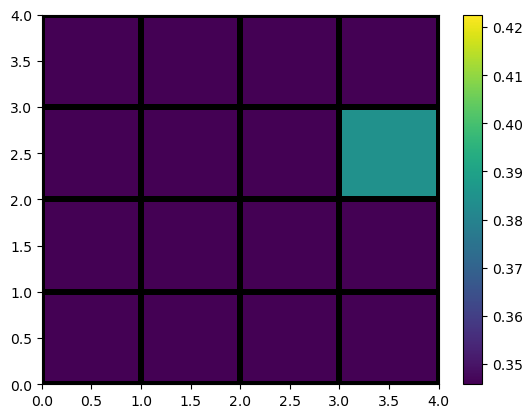

In [339]:
fig = plt.figure()
ax = fig.subplots()
psn = np.array([[ psn2(c, l) for l in lambs] for c in cs])
z = np.abs(np.mean(stats, axis=(2))-psn)#/np.mean(stats, axis=(2))
z_min, z_max = z.max(), z.max()
plt.pcolormesh(#lambs,cs, 
               z
               ,vmin=z_min, vmax=z_max,
                edgecolors='k', linewidths=4)
plt.colorbar()
#plt.xscale('log')
#plt.yscale('log')


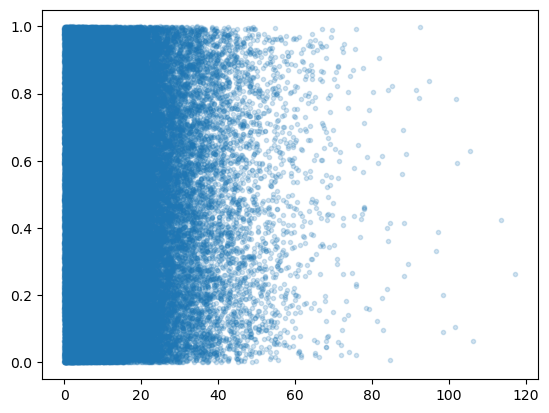

In [336]:
plt.scatter(rs, mus, marker='.', alpha=.2)

In [251]:
c = 1
lambda_ = 10
n_samples = 40000
sample_per_circle = 1
repeats = 10
stats = np.zeros(repeats)
for i in range(repeats):
    mus = np.random.uniform(0, c, n_samples)
    rs = np.random.exponential(lambda_, n_samples)
    points = np.array([sample_from_semi_circle(sample_per_circle, r,mu) 
                       for r,mu in zip(rs,mus)]).reshape((n_samples*sample_per_circle, 2))
    stats[i] = 1-(np.sum(points[:,0] >= 0)/n_samples)

In [252]:
psn(c, lambda_), np.mean(stats), np.std(stats), np.abs(psn(c, lambda_) - np.mean(stats))

(0.9957565425757183, 0.5947875, 0.0024251095336087283, 0.4009690425757183)

/tmp/ipykernel_31349/845474575.py:39: RuntimeWarning: divide by zero encountered in scalar divide
  return (2/(3*lamb*np.pi*c)) + (1/(np.pi))*partial_E()
/tmp/ipykernel_31349/845474575.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  - (r/c)*np.sqrt(1- (c/r)**2)
/tmp/ipykernel_31349/845474575.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  + (r/(3*c))*np.power(1- (c/r)**2, 3/2)
/tmp/ipykernel_31349/845474575.py:31: RuntimeWarning: invalid value encountered in scalar add
  return ((np.pi/2)
/tmp/ipykernel_31349/845474575.py:36: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(lambda r:


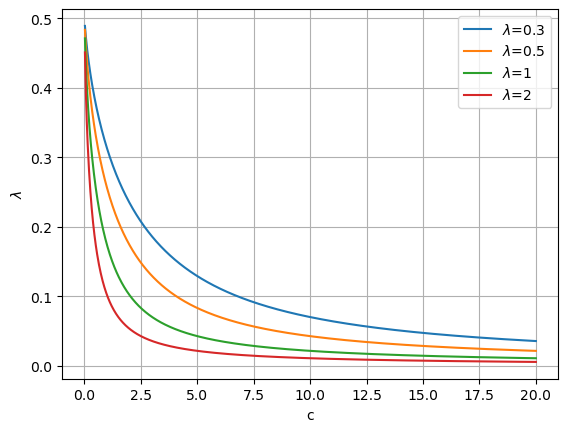

In [342]:
cs = np.linspace(0,20, 1000)
for l in [.3, .5, 1, 2]:
    plt.plot(cs,[psn2(c, l)for c in cs], label=r"$\lambda$=" f"{l}")
plt.xlabel('c');plt.ylabel(r'$\lambda$');plt.legend();plt.grid();plt.show()

In [350]:
def sample_matrix(n, S, p_diag, p_off_diag):
    """Sample a random matrix
       n:          the size of the matrix (n,n).
       S:          the average number of non-zero off-diagonal elements.
       p_diag:     The function that samples n elements for diagonal terms
                   it must have a signiture like p_diag(n,S).
       p_off_diag: The function that samples (n,n) elements for off-diagonal terms
                   it must have a signiture like p_off_diag(n,S).
    """
    
    # A binomial distribution with p=S/n always have the mean equals S
    # By setting N=1, we get 0 or one for each trials, which on average
    # S times is 1
    # So, the following create an n by n matrices of zeros and one such that
    # the expectation of getting non-zero element is S
    if S > n-1:
        p = 1.0
    else:
        p = S/(n-1)
    off_diag_indices = np.random.binomial(1, p, (n, n))
    # Since we sample the  diagonal terms differently, we fill their indices by one
    off_diag_indices[np.diag_indices(n)] = 0
    #print(off_diag_indices)
    
    # Create an n by n matrices, sampled from 'p_off_diag' distribution
    m = p_off_diag(n, S)
    #print(m)
    # Remove all the terms that is supposed to be zero (no regulation)
    # including the diagonals
    m = m*off_diag_indices
    #print(m)
    # Fill the diagonal terms by sampling from 'p_diag' distribution
    m[np.diag_indices(n)] = p_diag(n, S)
    #print(m)
    return m

def matrix_intervals(m, axis=1):
    """Turn a matrix to row(column)-wise intervals
    
       args:
           m: (n,n) numpy array.
           axis:  use one for row-wise and zero for
                  column-wise intervals.
    """
    # Get the diagonal terms
    ds = np.diag(m)
    # Sum of absolute value of off-diagonal elements
    rs = np.sum(np.abs(m - np.diag(ds)), axis = axis)
    # create intrvals around the diagonal terms
    return np.array([ (d-r, d+r) for d, r in zip(ds, rs) ])

def alg1(m, axis=1):
    """Specifies the stabaility property of the matrix.
    
       args:
           m: (n,n) numpy array.
           axis:  use one for row-wise and zero for
                  column-wise intervals.
       return:
               0 - super-stable
               1 - inconclusive
               2 - unstable
    
    """
    n = m.shape[0]
    intervals = matrix_intervals(m,axis)
    us = np.array([u for _,u in intervals])
    ls = np.array([l for l,_ in intervals])
    u_max_index = np.argmax(us)
    u_max = us[u_max_index]    
    if u_max < 0:# Super-stable
        return 0
    
    l_i = ls[u_max_index] 
    if l_i < 0:# Inconclusive
        return 1
    indices = [i for i in range(0, n) if i != u_max_index]
    for j in indices:
        l_j, u_j = ls[j], us[j]
        if l_i < u_j:
            if l_j < l_i:
                l_i = l_j
            if l_i < 0:# Inconclusive
                return 1
    return 2# unstable            

def alg2(m, axis=1):
    """Specifies if the stabaility property can be tightened.
    
       args:
           m: (n,n) numpy array.
           axis:  use one for row-wise and zero for
                  column-wise intervals.
       return:
               0 - super-stable
               1 - inconclusive
               2 - unstable
    
    """
    n = m.shape[0]
    # Get the diagonal terms
    ds = np.diag(m)
    # Sum of absolute value of off-diagonal elements
    rs = np.sum(np.abs(m - np.diag(ds)), axis = axis)
    a_max_index = np.argmax(ds)
    a_ii = ds[a_max_index]
    r_i = rs[a_max_index]
    indices = [i for i in range(0, n) if i != a_max_index]
    if a_ii > 0:        
        for j in indices:
            r_j = rs[j]
            a_jj = m[j,j]
            if axis == 0:
                a_ji = m[j, a_max_index]
            else:
                a_ji = m[a_max_index, j]
            c_0 = r_i
            c_1 = a_jj-a_ii+r_j-np.abs(a_ji)
            c_2 = np.abs(a_ji)                        
            d_max = np.real(np.max(np.roots([c_2, c_1, c_0])))
            if d_max <= r_i/a_ii:
                return 1 # Inconclusive
            if c_1 >= 0:                
                return 1 # Inconclusive
            if c_1*c_1 <= 4*np.abs(a_ji*r_i):                
                return 1 # Inconclusive
        return 2 # Unstable
    else:
        #r_j = rs[j]
        #a_jj = m[j,j]
        #a_ji = m[j, a_max_index]
        #if r_i/np.abs(a_ii) >= np.min([ (np.abs(a_jj)-r_j)/np.abs(a_ji)  for j in indices]):
        # select r_i, a_jj and a_ji
        if axis == 0:
            parts = [(rs[j], m[j,j], m[j, a_max_index]) for j in indices]
        else:
            parts = [(rs[j], m[j,j], m[a_max_index, j]) for j in indices]
        values = [(np.abs(a_jj)-r_j)/np.abs(a_ji)  for (r_j, a_jj, a_ji) in parts]
        if r_i/np.abs(a_ii) >= np.min(values):
            return 1 # Inconclusive
        return 0 # Super-stable

def alg(m):
    ret = alg1(m, axis = 0)
    if ret != 1:
        return ret
    ret = alg1(m, axis = 1)
    if ret != 1:
        return ret
    ret = alg2(m, axis = 0)
    if ret != 1:
        return ret
    return alg2(m, axis = 1)

In [698]:
def p_diag_uniform(low):
    def uniform(n, S):
        return np.random.uniform(low, 0, n)    
    return uniform

def p_off_diag_exp(lamb):
    def exp(n, S):        
        p = np.random.uniform(0, 1)        
        return (
            np.random.exponential(1/lamb, (n,n))*
            np.where(np.random.binomial(1, p, (n, n)) == 0, -1, 1)
            #np.where(np.random.randint(0,2, (n,n)) ==0, -1, 1)
        )
    return exp

def is_unstable(m):
    """Find the linear stability of a matrix"""
    return np.any(np.real(sp.linalg.eigvals(m)) > 0)

(array([1.708e+03, 1.757e+03, 9.670e+02, 3.860e+02, 1.260e+02, 4.700e+01,
        8.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 0.        ,  2.46290177,  4.92580354,  7.38870532,  9.85160709,
        12.31450886, 14.77741063, 17.2403124 , 19.70321417, 22.16611595,
        24.62901772]),
 <BarContainer object of 10 artists>)

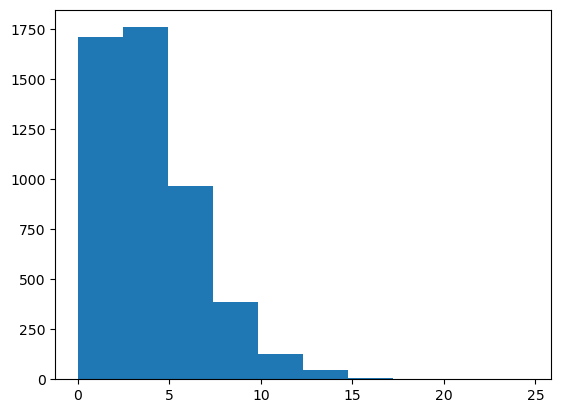

In [721]:
m=sample_matrix(5000, 4 ,#n-1, 
                    p_diag_uniform(-c), 
                    p_off_diag_exp(lamb))
plt.hist(np.sum(np.abs(m - np.diag(np.diag(m))), axis=1))

In [754]:
count = 500
ns = np.array([5, 10, 50, 100, 500])
c = 10
lamb = 1.0
repeats = 3
stats = np.zeros((ns.shape[0], repeats))
s = .4
for i,n in enumerate(ns):
    print(f"n:{n}")
    for j in range(repeats):
        matrcies = [sample_matrix(n, int(s*n) ,#4,#n-1, 
                    p_diag_uniform(-c), 
                    p_off_diag_exp(lamb*n)) for _ in range(count)]
        regimes = np.array([alg(m) for m in matrcies])
        matrices2 = np.array([m for m, s in zip(matrcies, regimes) if s == 1])
        unstables = np.array([is_unstable(m) for m in matrices2])
        stats[i,j] = np.sum(unstables)/unstables.size


n:5
n:10


/tmp/ipykernel_31349/3879707423.py:148: RuntimeWarning: divide by zero encountered in scalar divide
  values = [(np.abs(a_jj)-r_j)/np.abs(a_ji)  for (r_j, a_jj, a_ji) in parts]


n:50
n:100
n:500


In [755]:
stats

array([[0.33333333, 0.14285714, 0.07142857],
       [0.08888889, 0.11111111, 0.08333333],
       [0.00651466, 0.0137457 , 0.01342282],
       [0.00655022, 0.00438596, 0.00890869],
       [0.004     , 0.006     , 0.01      ]])

In [752]:
stats

array([[0.375     , 0.14285714, 0.33333333],
       [0.        , 0.07692308, 0.        ],
       [0.00787402, 0.00917431, 0.        ],
       [0.01086957, 0.00558659, 0.00552486],
       [0.01      , 0.005     , 0.005     ]])

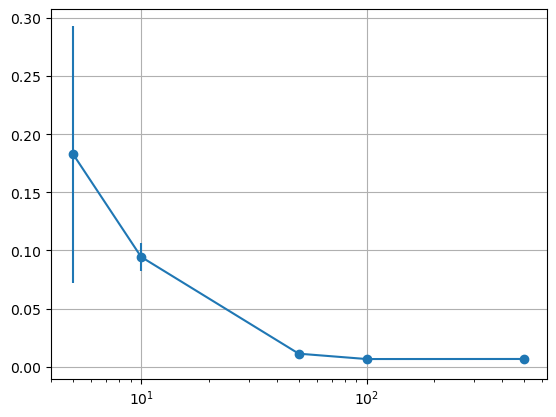

In [756]:
plt.errorbar(ns, np.mean(stats, axis=1) , yerr=np.std(stats, axis=1), fmt='-o')
plt.xscale('log');plt.grid()

In [680]:
count = 1000
n = 10
c = 10
lamb = 1.0
matrcies = [sample_matrix(n,n-1, 
                          p_diag_uniform(-c), 
                          p_off_diag_exp(lamb)) for _ in range(count)]

In [681]:
regimes = np.array([alg(m) for m in matrcies])

In [682]:
matrices2 = np.array([m for m, s in zip(matrcies, regimes) if s == 1])

In [683]:
unstables = np.array([is_unstable(m) for m in matrices2])

In [684]:
import math
def psn3(c, lamb, k):
        
    def second_int(r):
        return ((np.pi/2) 
                - (r/c)*np.sqrt(1- (c/r)**2)
                + (r/(3*c))*np.power(1- (c/r)**2, 3/2)
                - np.arcsin(c/r))
    def partial_E():
        return integrate.quad(lambda r: 
            second_int(r) * (lamb**k) * (r**(k-1)) * np.exp(-lamb*r)/math.factorial(k-1),
                              c, np.inf)[0]
    return (2*k/(3*lamb*np.pi*c)) + (1/(np.pi))*partial_E()

In [687]:
np.sum(unstables)/unstables.size

0.643

In [626]:
1-psn3(c, lamb, n-1)

0.8118397991537254

In [627]:


def plot_matrix(m, axis=1):
    # matrix eigenvalues
    eigens = sp.linalg.eigvals(m)
    # Get the diagonal terms
    ds = np.diag(m)
    # Sum of absolute value of off-diagonal elements
    rs = np.sum(np.abs(m - np.diag(ds)), axis = axis)
    #
    fig = plt.figure()
    ax = fig.subplots()
    for i in range(m.shape[0]):
        circle1 = plt.Circle((ds[i], 0), rs[i], alpha=.1)#, color='yellow')
        ax.add_patch(circle1)
    for i in range(m.shape[0]):
        ax.scatter(np.real(eigens[i]), np.imag(eigens[i]),color='red', marker='x', alpha=1)        
        
    #ax.set_aspect('equal', adjustable='box')
    

In [761]:
is_unstable(matrices2[1])

False

(-1.0, 0.2)

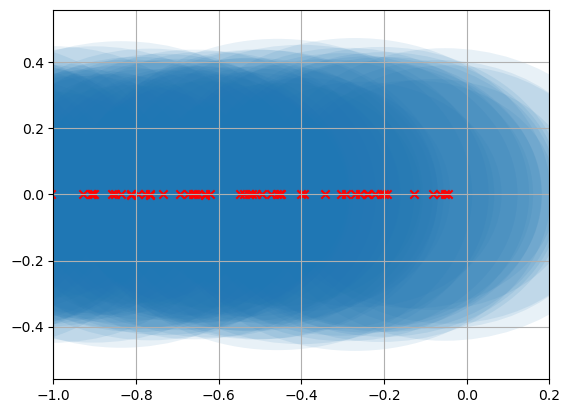

In [762]:
plot_matrix(matrices2[2])
plt.grid();plt.xlim(-1,.2)

In [610]:
off_d_1 = np.array([np.sum(np.abs(m[0,1:])) for m in matrices2])
off_d_2 = np.array([np.sum(np.abs(np.hstack([m[1,:1], m[1,2:]]))) for m in matrices2])
off_d_3 = np.array([np.sum(np.abs(np.hstack([m[2,:2], m[2,3:]]))) for m in matrices2])
off_d_4 = np.array([np.sum(np.abs(np.hstack([m[3,:3], m[3,4:]]))) for m in matrices2])
off_ds = np.hstack([off_d_1, off_d_2, off_d_3, off_d_4])

OverflowError: (34, 'Numerical result out of range')

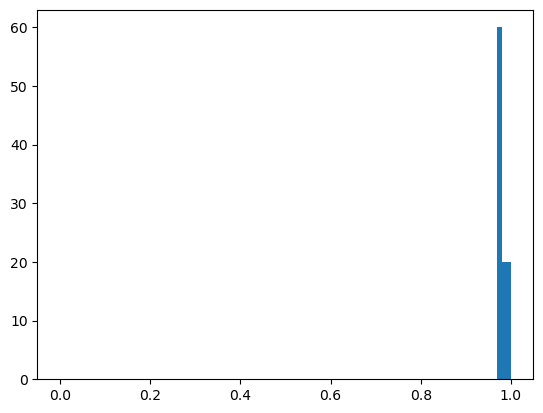

In [613]:
def erlang(x, lamb, k):
    return (lamb**k) * (x**(k-1)) * np.exp(-lamb*x)/math.factorial(k-1)

bins = np.linspace(0, 1, 101)
plt.hist(off_d_4, bins=bins, density=True)
plt.plot(bins, erlang(bins, lamb, n-1))

/tmp/ipykernel_31349/1243674563.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  return (2*k/(3*lamb*np.pi*c)) + (1/(np.pi))*partial_E()
/tmp/ipykernel_31349/1243674563.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  - (r/c)*np.sqrt(1- (c/r)**2)
/tmp/ipykernel_31349/1243674563.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  + (r/(3*c))*np.power(1- (c/r)**2, 3/2)
/tmp/ipykernel_31349/1243674563.py:5: RuntimeWarning: invalid value encountered in scalar add
  return ((np.pi/2)
/tmp/ipykernel_31349/1243674563.py:10: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(lambda r:


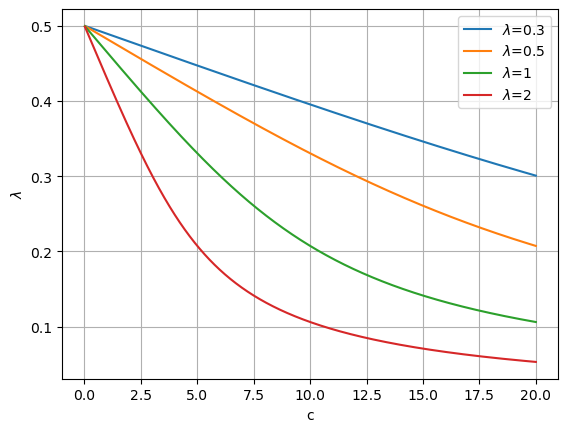

In [484]:
cs = np.linspace(0,20, 1000)
for l in [.3, .5, 1, 2]:
    plt.plot(cs,[psn3(c, l, 10)for c in cs], label=r"$\lambda$=" f"{l}")
plt.xlabel('c');plt.ylabel(r'$\lambda$');plt.legend();plt.grid();plt.show()

In [780]:
c = 1
alpha = c/4
n_samples = 40000
sample_per_circle = 1000
repeats = 10
stats = np.zeros(repeats)
for i in range(repeats):
    mus = np.random.uniform(0, c, n_samples)
    rs =  np.ones(n_samples) * alpha
    points = np.array([sample_from_semi_circle(sample_per_circle, r,mu) 
                       for r,mu in zip(rs,mus)]).reshape((n_samples*sample_per_circle, 2))
    stats[i] = (np.sum(points[:,0] >= 0)/(sample_per_circle*n_samples))

In [781]:
2*alpha/(3*np.pi*c), np.mean(stats), np.std(stats)

(0.05305164769729845, 0.053436649999999995, 0.0006044835098040304)

In [810]:
def fixed_radius_matrices(n, alpha, p_diag, p_off_diag):
    """Sample a random matrix
       n:          the size of the matrix (n,n).
       alpha:      the radius Gershgorin circles.
       p_diag:     The function that samples n elements for diagonal terms
                   it must have a signiture like p_diag(n).
       p_off_diag: The function that samples (n-1) elements for off-diagonal terms
                   it must have a signiture like p_off_diag(n).
    """
    
    # Create an n by n matrices, sampled from 'p_off_diag' distribution
    def row_gen(l, ds):
        for i in range(l):
            r = p_off_diag(l-2)
            while np.sum(np.abs(r)) > alpha:
                r = p_off_diag(l-2)
            
            p = .5
            r *= np.where(np.random.binomial(1, p, l-2) == 0, -1, 1)
            index = np.random.choice(range(0,l-2), 1)[0] 
            if index == 0:
                r = np.hstack([[alpha-np.sum(np.abs(r))], r])
            elif index == l-3:
                r = np.hstack([r , [alpha-np.sum(np.abs(r))]])
            else:
                r = np.hstack([r[:index] , [alpha-np.sum(np.abs(r))], r[index:]])
            if i == 0:
                yield np.hstack([ds[0], r])
            elif i==l-1:
                yield np.hstack([r, ds[-1]])
            else:
                yield np.hstack([r[:i], ds[i], r[i:]])
    ds = p_diag(n)
    m = np.vstack([r for r in row_gen(n, ds)]) 
    return m
#     #print(m)
#     # Remove all the terms that is supposed to be zero (no regulation)
#     # including the diagonals
#     m = m*off_diag_indices
#     #print(m)
#     # Fill the diagonal terms by sampling from 'p_diag' distribution
#     m[np.diag_indices(n)] = p_diag(n, S)
#     #print(m)
#    return m
    
def p_diag_uniform(low):
    def uniform(n):
        return np.random.uniform(low, 0, n)    
    return uniform

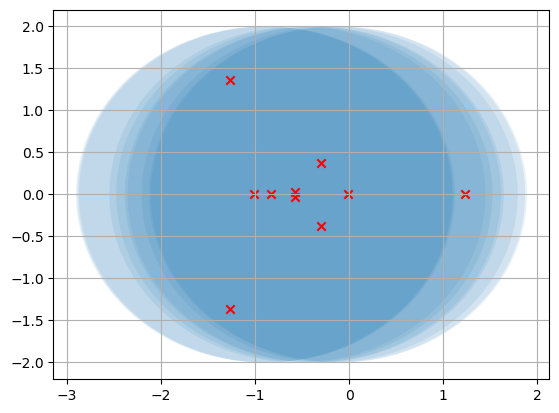

In [817]:
plot_matrix(fixed_radius_matrices(10, 2, p_diag_uniform(-1), p_diag_uniform(.1)))
plt.grid();

In [831]:
count = 500
#ns = np.array([5, 10, 50, 100, 500])
ns = np.array([10, 20, 30, 50, 100, 200, 300, 400, 500])
c = 10
alphas = np.array([c/2, c/4, c/10])
repeats = 10
stats = np.zeros((ns.shape[0], alphas.shape[0], repeats))
for i,n in enumerate(ns):
    for k,alpha in enumerate(alphas):
        print(f"n:{n}, alpha:{alpha}")
        for j in range(repeats):
            matrcies = [fixed_radius_matrices(n, alpha, 
                                              p_diag_uniform(-c), 
                                              p_diag_uniform(alpha/n)) for _ in range(count)]
            regimes = np.array([alg(m) for m in matrcies])
            matrices2 = np.array([m for m, s in zip(matrcies, regimes) if s == 1])
            unstables = np.array([is_unstable(m) for m in matrices2])
            stats[i, k ,j] = np.sum(unstables)/unstables.size


n:10, alpha:5.0
n:10, alpha:2.5
n:10, alpha:1.0
n:20, alpha:5.0
n:20, alpha:2.5
n:20, alpha:1.0
n:30, alpha:5.0
n:30, alpha:2.5
n:30, alpha:1.0
n:50, alpha:5.0
n:50, alpha:2.5
n:50, alpha:1.0
n:100, alpha:5.0
n:100, alpha:2.5
n:100, alpha:1.0
n:200, alpha:5.0
n:200, alpha:2.5
n:200, alpha:1.0
n:300, alpha:5.0
n:300, alpha:2.5
n:300, alpha:1.0
n:400, alpha:5.0
n:400, alpha:2.5
n:400, alpha:1.0
n:500, alpha:5.0
n:500, alpha:2.5
n:500, alpha:1.0


In [835]:
stats.shape, alphas.shape, ns.shape

((9, 3, 10), (3,), (9,))

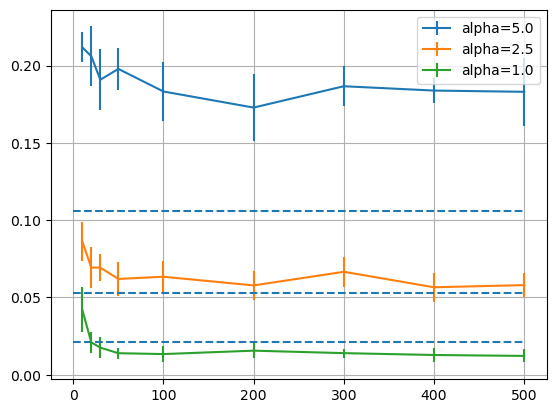

In [844]:
for k,alpha in enumerate(alphas):
    plt.errorbar(ns, np.mean(stats[:,k,:], axis=1),
                 yerr=np.std(stats[:,k,:], axis=1), label=f"alpha={alpha}")
    plt.hlines(2*alpha/(3*np.pi*c), 0, ns[-1], linestyles='--')

plt.grid();plt.legend();plt.show()

In [895]:
n = 10
alphas = np.array([c, c*.9, c*.75, c/2, c/4, c/8, c/10])
c = 10
repeats = 20000
sample_per_circle = 1000
stats2 = np.zeros((repeats, alphas.shape[0]))
stats_left_circles = np.zeros((repeats, alphas.shape[0]))
stats_unstables = np.zeros((alphas.shape[0]))
for k,alpha in enumerate(alphas):
    unstables_count = 0
    for i in range(repeats):
        m = fixed_radius_matrices(n, alpha, p_diag_uniform(-c), p_diag_uniform(alpha/n))
        if alg(m) != 1:
            m = fixed_radius_matrices(n, alpha, p_diag_uniform(-c), p_diag_uniform(alpha/n))
        
        
        if is_unstable(m):
            unstables_count+=1
        rs = np.sum(np.abs(m - np.diag(np.diag(m))), axis=1)
        mus = np.diag(m)
        stats_left_circles[i,k] = np.sum(rs+mus < 0)/n
        points = np.array([sample_from_semi_circle(sample_per_circle, r,mu) 
                       for r,mu in zip(rs,mus)]).reshape((n*sample_per_circle, 2))
        stats2[i,k] = 1-(np.sum(points[:,0] >= 0)/(n*sample_per_circle))
    stats_unstables[k] =   unstables_count/repeats 
    prob = 2*alpha/(3*np.pi*c)
    prob2 = (1-prob)**n
    print(f"alpha: {alpha}")
    print(f"Bound:{prob:.4f}, Bound2:{prob2:.4f},{1-prob2:.4f}")
    print(f"Sampled in left:{np.mean(stats2[:, k]):.4f} +- {np.std(stats2[:, k]):.5f}")
    print(f"Percentage of circles on the left: {np.mean(stats_left_circles[:, k]):.4f} +- {np.std(stats_left_circles[:, k]):.5f}")
    print(f"Percentage of unstable matrices: {stats_unstables[k]:.4f}, {1-stats_unstables[k]:.4f}")
    print()


alpha: 10.0
Bound:0.2122, Bound2:0.0921,0.9079
Sampled in left:0.2127 +- 0.04835
Percentage of circles on the left: 0.0000 +- 0.00000
Percentage of unstable matrices: 0.8978, 0.1022

alpha: 9.0
Bound:0.1910, Bound2:0.1201,0.8799
Sampled in left:0.1910 +- 0.04988
Percentage of circles on the left: 0.0996 +- 0.09430
Percentage of unstable matrices: 0.8385, 0.1615

alpha: 7.5
Bound:0.1592, Bound2:0.1767,0.8233
Sampled in left:0.1593 +- 0.05051
Percentage of circles on the left: 0.2498 +- 0.13717
Percentage of unstable matrices: 0.7129, 0.2871

alpha: 5.0
Bound:0.1061, Bound2:0.3257,0.6743
Sampled in left:0.1069 +- 0.04777
Percentage of circles on the left: 0.4972 +- 0.15664
Percentage of unstable matrices: 0.4326, 0.5674

alpha: 2.5
Bound:0.0531, Bound2:0.5798,0.4202
Sampled in left:0.0596 +- 0.03581
Percentage of circles on the left: 0.7211 +- 0.12406
Percentage of unstable matrices: 0.1552, 0.8448

alpha: 1.25
Bound:0.0265, Bound2:0.7643,0.2357
Sampled in left:0.0360 +- 0.02925
Percenta

In [900]:
ns = np.array([10, 20, 30, 50, 100, 200, 300, 400, 500, 1000])
alphas = np.array([c, c*.9, c*.75, c/2, c/4, c/8, c/10])
c = 10
repeats = 20000
sample_per_circle = 1000
#stats2 = np.zeros((ns.shape[0],repeats, alphas.shape[0]))
#stats_left_circles = np.zeros((ns.shape[0], repeats, alphas.shape[0]))
stats_unstables = np.zeros((ns.shape[0], alphas.shape[0]))
stats_P_S = np.zeros((ns.shape[0], alphas.shape[0]))
estimated_P_S = np.zeros((ns.shape[0], alphas.shape[0]))
for j,n in enumerate(ns):
    for k,alpha in enumerate(alphas):
        unstables_count = 0
        for i in range(repeats):
            m = fixed_radius_matrices(n, alpha, p_diag_uniform(-c), p_diag_uniform(alpha/n))
            if alg(m) != 1:
                m = fixed_radius_matrices(n, alpha, p_diag_uniform(-c), p_diag_uniform(alpha/n))

            if is_unstable(m):
                unstables_count+=1
            #rs = np.sum(np.abs(m - np.diag(np.diag(m))), axis=1)
            #mus = np.diag(m)
            #stats_left_circles[j,i,k] = np.sum(rs+mus < 0)/n
            #points = np.array([sample_from_semi_circle(sample_per_circle, r,mu) 
            #               for r,mu in zip(rs,mus)]).reshape((n*sample_per_circle, 2))
            #stats2[j, i, k] = 1-(np.sum(points[:,0] >= 0)/(n*sample_per_circle))
        stats_unstables[j, k] =   unstables_count/repeats 
        prob = 2*alpha/(3*np.pi*c)
        prob2 = (1-prob)**n
        estimated_P_S[j, k] = prob2
        stats_P_S[j,k] = 1-stats_unstables[j, k]
        print(f"n:{n}, alpha: {alpha}, Bound:{prob:.4f}, Bound2:{prob2:.4f}")
        print(f"Percentage of stable matrices:  {stats_P_S[j, k]:.4f}")
        print()


n:10, alpha: 10.0, Bound:0.2122, Bound2:0.0921
Percentage of stable matrices:  0.1055

n:10, alpha: 9.0, Bound:0.1910, Bound2:0.1201
Percentage of stable matrices:  0.1675

n:10, alpha: 7.5, Bound:0.1592, Bound2:0.1767
Percentage of stable matrices:  0.2847

n:10, alpha: 5.0, Bound:0.1061, Bound2:0.3257
Percentage of stable matrices:  0.5740

n:10, alpha: 2.5, Bound:0.0531, Bound2:0.5798
Percentage of stable matrices:  0.8440

n:10, alpha: 1.25, Bound:0.0265, Bound2:0.7643
Percentage of stable matrices:  0.9377

n:10, alpha: 1.0, Bound:0.0212, Bound2:0.8070
Percentage of stable matrices:  0.9565

n:20, alpha: 10.0, Bound:0.2122, Bound2:0.0085
Percentage of stable matrices:  0.0557

n:20, alpha: 9.0, Bound:0.1910, Bound2:0.0144
Percentage of stable matrices:  0.1045

n:20, alpha: 7.5, Bound:0.1592, Bound2:0.0312
Percentage of stable matrices:  0.2186

n:20, alpha: 5.0, Bound:0.1061, Bound2:0.1061
Percentage of stable matrices:  0.5371

n:20, alpha: 2.5, Bound:0.0531, Bound2:0.3361
Perce

KeyboardInterrupt: 

In [909]:
ns = np.array([4, 8, 16, 32, 64, 128, 256])
c = 10
alphas = np.array([c, c*.9, c*.75, c/2, c/4, c/8, c/10])
repeats = 200
#sample_per_circle = 1000
#stats2 = np.zeros((ns.shape[0],repeats, alphas.shape[0]))
#stats_left_circles = np.zeros((ns.shape[0], repeats, alphas.shape[0]))
stats_unstables = np.zeros((ns.shape[0], alphas.shape[0]))
stats_P_S = np.zeros((ns.shape[0], alphas.shape[0]))
estimated_P_S = np.zeros((ns.shape[0], alphas.shape[0]))
for j,n in enumerate(ns):
    for k,alpha in enumerate(alphas):
        unstables_count = 0
        for i in range(repeats):
            m = fixed_radius_matrices(n, alpha, p_diag_uniform(-c), p_diag_uniform(alpha/n))
            if alg1(m) != 1:
                m = fixed_radius_matrices(n, alpha, p_diag_uniform(-c), p_diag_uniform(alpha/n))

            if is_unstable(m):
                unstables_count+=1
            #rs = np.sum(np.abs(m - np.diag(np.diag(m))), axis=1)
            #mus = np.diag(m)
            #stats_left_circles[j,i,k] = np.sum(rs+mus < 0)/n
            #points = np.array([sample_from_semi_circle(sample_per_circle, r,mu) 
            #               for r,mu in zip(rs,mus)]).reshape((n*sample_per_circle, 2))
            #stats2[j, i, k] = 1-(np.sum(points[:,0] >= 0)/(n*sample_per_circle))
        stats_unstables[j, k] =   unstables_count/repeats 
        prob = 2*alpha/(3*np.pi*c)
        prob2 = (1-prob)**n
        estimated_P_S[j, k] = prob2
        stats_P_S[j,k] = 1-stats_unstables[j, k]
        print(f"n:{n}, alpha: {alpha}, Bound:{prob:.4f}, Bound2:{prob2:.4f}")
        print(f"Percentage of stable matrices:  {stats_P_S[j, k]:.4f}")
        print()


n:4, alpha: 10.0, Bound:0.2122, Bound2:0.3852
Percentage of stable matrices:  0.0800

n:4, alpha: 9.0, Bound:0.1910, Bound2:0.4284
Percentage of stable matrices:  0.1800

n:4, alpha: 7.5, Bound:0.1592, Bound2:0.4999
Percentage of stable matrices:  0.2900

n:4, alpha: 5.0, Bound:0.1061, Bound2:0.6385
Percentage of stable matrices:  0.5050

n:4, alpha: 2.5, Bound:0.0531, Bound2:0.8041
Percentage of stable matrices:  0.7950

n:4, alpha: 1.25, Bound:0.0265, Bound2:0.8980
Percentage of stable matrices:  0.9400

n:4, alpha: 1.0, Bound:0.0212, Bound2:0.9178
Percentage of stable matrices:  0.9400

n:8, alpha: 10.0, Bound:0.2122, Bound2:0.1484
Percentage of stable matrices:  0.1300

n:8, alpha: 9.0, Bound:0.1910, Bound2:0.1835
Percentage of stable matrices:  0.1700

n:8, alpha: 7.5, Bound:0.1592, Bound2:0.2499
Percentage of stable matrices:  0.3100

n:8, alpha: 5.0, Bound:0.1061, Bound2:0.4077
Percentage of stable matrices:  0.6000

n:8, alpha: 2.5, Bound:0.0531, Bound2:0.6466
Percentage of sta

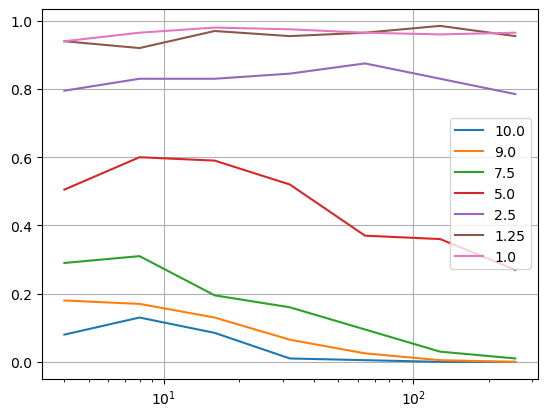

In [910]:
for k,alpha in enumerate(alphas):
    plt.plot(ns, stats_P_S[:, k], label=f"{alpha}")
    
plt.legend();plt.grid();plt.xscale('log');plt.show()

In [911]:
from multiprocessing import Pool, shared_memory
class _LocalFunctions:
    @classmethod
    def add_functions(cls, *args):
        for function in args:
            setattr(cls, function.__name__, function)
            function.__qualname__ = cls.__qualname__ + '.' + function.__name__

In [919]:
ns = np.array([4, 8, 16, 32, 64, 128, 256])
c = 10
alphas = np.array([c, c*.9, c*.75, c/2, c/4, c/8, c/10])
repeats = 10
trials = 10000
def proc_stability(args):
    n, alpha, c, trials = args
    unstables_count = 0
    for i in range(repeats):
        m = fixed_radius_matrices(n, alpha, p_diag_uniform(-c), p_diag_uniform(alpha/n))
        #if alg1(m) != 1:
        #    m = fixed_radius_matrices(n, alpha, p_diag_uniform(-c), p_diag_uniform(alpha/n))

        if is_unstable(m):
            unstables_count+=1
    
    prob = 2*alpha/(3*np.pi*c)
    prob2 = (1-prob)**n
    return (1-unstables_count/repeats, prob, prob2)

params = [ (n, alpha, c, trials) for n in ns for alpha in alphas]
with Pool(55) as pool:
    res = pool.map(proc_stability, params)

In [947]:
stats_unstables = np.zeros((ns.shape[0], alphas.shape[0]))
stats_P_S = np.zeros((ns.shape[0], alphas.shape[0]))
estimated_level = np.zeros((ns.shape[0], alphas.shape[0]))
estimated_P_S = np.zeros((ns.shape[0], alphas.shape[0]))
for j,n in enumerate(ns):
    for k,alpha in enumerate(alphas):
        stats_unstables[j, k] =   1-res[j*alphas.shape[0] + k][0]
        stats_P_S[j,k] = res[j*alphas.shape[0] + k][0]
        estimated_level[j, k] = res[j*alphas.shape[0] + k][1]
        estimated_P_S[j, k] = res[j*alphas.shape[0] + k][2]
        


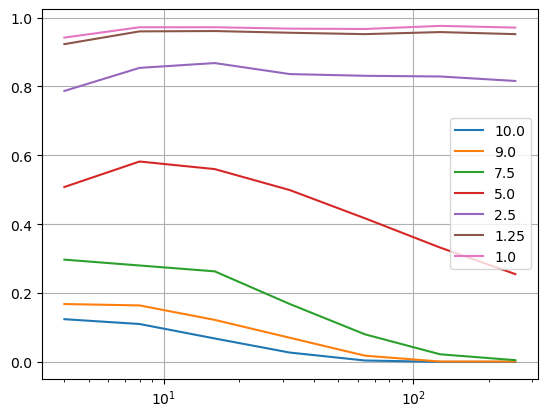

In [921]:
for k,alpha in enumerate(alphas):
    plt.plot(ns, stats_P_S[:, k], label=f"{alpha}")
    
plt.legend();plt.grid();plt.xscale('log');plt.show()

In [961]:
ns = np.array([4, 8, 16, 32, 64, 128, 256])
c = 10
alphas = np.array([c])
repeats = 10
trials = 10000
def proc_stability2(args):
    n, alpha, c, trials, repeats = args
    unstables_count = 0
    for i in range(trials):
        m = fixed_radius_matrices(n, alpha, p_diag_uniform(-c), p_diag_uniform(alpha/n))
        if alg(m) != 1:
            m = fixed_radius_matrices(n, alpha, p_diag_uniform(-c), p_diag_uniform(alpha/n))

        if is_unstable(m):
            unstables_count+=1
    
    prob = 2*alpha/(3*np.pi*c)
    prob2 = (1-prob)**n
    return (1-unstables_count/trials, prob, prob2)

params2 = [ (n, alpha, c, trials, t) for n in ns for alpha in alphas for t in range(repeats)]
with Pool(55) as pool:
    res2 = pool.map(proc_stability2, params2)

ZeroDivisionError: division by zero

In [ ]:
stats_unstables2 = np.zeros((ns.shape[0], alphas.shape[0], repeats))
stats_P_S2 = np.zeros((ns.shape[0], alphas.shape[0], repeats))
estimated_level2 = np.zeros((ns.shape[0], alphas.shape[0], repeats))
estimated_P_S2 = np.zeros((ns.shape[0], alphas.shape[0], repeats))
for j,n in enumerate(ns):
    for k,alpha in enumerate(alphas):
        for t in range(repeats):
            index = j*alphas.shape[0]*repeats + k*repeats + t
            stats_unstables2[j, k, t ] =   1- res2[index][0]
            stats_P_S2[j,k, t] = res2[index][0]
            estimated_level2[j, k,t] = res2[index][1]
            estimated_P_S2[j, k,t] = res2[index][2]

In [ ]:
plt.plot(ns, np.power(stats_P_S2[:, 0], 1/ns))
plt.xscale('log')